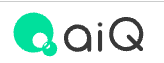

[disclaimer](../../disclaimer.txt/)

# aiQ Pos Consumer Goods/Elec/Retailer Evenly

本サンプルノートブックでは以下の3つのオルタナティブデータのファクターリターンをそれぞれ作成し、1/3ずつ資産配分をした合成ポートフォリオを考えます。
それぞれのファクターリターンの相関が低いことと、合成ポートフォリオの高いパフォーマンスが確認できます。


- aiQ POS Csmr Goods
- POS Elec Goods
- POS Retaiきます。

In [1]:
# 自作モジュールを自動更新を行うためのコマンド
%load_ext autoreload
%autoreload 2

## Step1: Import Library

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.io
from pathlib import Path
from aiq_strategy_robot.data.data_accessor import DAL

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

# 
if '../..' not in sys.path:
    sys.path.append('../..')

from utils.shortcut import goods_dataset as sc_goods
from utils.shortcut import elec_dataset as sc_elec
from utils.shortcut import aiq_pos_retailer as sc_retailer
from utils.shortcut.path import DEFAULT_DIR

- standard data handler のインスタンスを作成する
- data handler はデータ取得やデータ加工のライブラリを保持するオブジェクト

In [3]:
verbose = False
sdh = DAL()
sdh.transform.verbose = verbose

## Step2: Load Data to `sdh`
ここではデータ分析のデモが主眼であるため、個別に用意しておいた簡易ローダーを経由してデータを読み込むこととする

In [4]:
f_ticker_cvt = lambda s: f"{s[:4]}-JP"
sc_retailer.load_sample_dataset(sdh,  f_ticker_cvt=f_ticker_cvt)  # for retailer
dat_id_retail = 1
data_id_goods = sc_goods.register_alt_data(sdh, f_ticker_cvt=f_ticker_cvt)
data_id_elec = sc_elec.register_elec_data(sdh)
data_id_mkt = sc_elec.load_finnhub_equity_data_fixed_ticker(sdh, data_dir=DEFAULT_DIR)
display(sdh.extract_definition)

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,aiq_pos_retailer,Unknown,Unknown,Unknown,"[1925-JP, 2212-JP, 2267-JP, 2651-JP, 2653-JP, ...","[TICKER, DATETIME]",2010-04-30 00:00:00,2024-06-30 00:00:00
2,RawData,mkt,Unknown,Unknown,Unknown2,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-06-19 00:00:00
3,RawData,finnhub,fundamental,Unknown,Unknown3,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[TICKER, DATETIME]",2014-06-30 00:00:00,2024-02-29 00:00:00
4,RawData,external,sample,Unknown,Unknown4,"[1301-JP, 1332-JP, 1333-JP, 1334-JP, 1352-JP, ...","[TICKER, DATETIME]",2008-03-16 00:00:00,2024-06-30 00:00:00
5,RawData,External,Unknown,Unknown,Unknown5,"[1956-JP, 2180-JP, 2321-JP, 2323-JP, 2326-JP, ...","[TICKER, DATETIME]",2009-01-01 00:00:00,2024-06-30 00:00:00
6,RawData,External,Unknown,Unknown,Unknown6,"[1301-JP, 1332-JP, 1333-JP, 1379-JP, 1380-JP, ...","[TICKER, DATETIME]",2007-01-04 00:00:00,2024-07-03 00:00:00


### データが `sdh` に登録できたかを確認する

In [5]:
sdh.set_alias(
    {dat_id_retail: 'retail', data_id_goods: 'goods', 
     data_id_elec: 'elec', data_id_mkt: 'mkt'})

## Step3: 個々のデータセットのファクタリターンを確認する
組み合わせる前に、個々のファクターリターンのパフォーマンスを確認

In [6]:
# Step3 で使うオブジェクトをロードしておく
from aiq_strategy_robot.evaluator import AltDataEvaluator, inv_return_stats, cumplot_return

In [7]:
# データ評価に使うメインクラスのインスタンスを作成
ade = AltDataEvaluator(sdh)

In [8]:
# 市場データを生値から変化率に変換しておく
bcktest_return_id = sdh.transform.log_diff(1, data_id=data_id_mkt, fields='close').variable_ids[0]

### Step3.1: POS CSMR Goods
- weekly のリバランス
- データは最短でも週末から4営業日のラグ

In [9]:
n_shift = 6    # データ発行のタイミングラグを考慮
n_rolling = 12 # 3ヶ月の移動平均を計算
n_diff = 52    # 前年同週比を計算

In [10]:
signal_goods_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_goods)
    .resample('W', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=7)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [11]:
nq = 3
exe_cost = 0.0005

dfqret_goods, stats, dfsigqt = ade.q_backtest(
    signal_goods_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.356947,0.023675,0.136318,0.173677,0.538253,8.913233,-0.523942,0.045187
#2,0.988268,0.065549,0.135363,0.484249,0.545849,12.448515,-0.433866,0.151082
#3,1.211641,0.080365,0.137630,0.583922,0.557515,8.883923,-0.406785,0.197562
#3-#1,0.854694,0.056690,0.050049,1.132677,0.534455,17.797156,-0.090179,0.628634
#3-#1(cost),0.720533,0.047791,0.050062,0.954637,0.528486,17.797156,-0.097439,0.490473


### Step3: POS Retailer
- monthly のリバランス
- データは最短でも月末から5営業日のラグ

In [12]:
n_shift = 7   # データ発行のタイミングラグを考慮
n_rolling = 2 # 2ヶ月の移動平均を計算（データが月次のため）
n_diff = 12   # 前年同月比を計算

In [13]:
signal_retailer_id = (
    sdh.transform
    .multiply('pos_sales', 'share', data_id=dat_id_retail)
    .resample('M', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=31)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [14]:
nq = 3
exe_cost = 0.0005

dfqret_retailer, stats, dfsigqt = ade.q_backtest(
    signal_retailer_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.578859,0.044266,0.137865,0.321085,0.528308,10.162120,-0.604328,0.073249
#2,1.153415,0.088204,0.142697,0.618118,0.540820,11.429750,-0.450649,0.195726
#3,1.770004,0.135355,0.144877,0.934280,0.548327,8.522967,-0.410303,0.329892
#3-#1,1.191145,0.091089,0.069840,1.304249,0.537379,18.685087,-0.126101,0.722347
#3-#1(cost),1.068976,0.081747,0.069846,1.170389,0.532061,18.685087,-0.129279,0.632325


### Step3.3: POS Elec Goods
- daily のリバランス
- データは最短でも3営業日のラグ

In [15]:
n_shift = 8    # データ発行のタイミングラグを考慮
n_rolling = 14 # 14日の移動平均を計算（データは日次）
n_diff = 252   # 前年同日比を取るため
min_period = int(max(np.floor(n_rolling * 5 / 7), 1))

In [16]:
signal_elec_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_elec)
    .resample('D', 'last')
    .sma(n_rolling, min_period)
    .reindex(label=bcktest_return_id)
    .log_diff(n_diff)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [17]:
nq = 3
exe_cost = 0.0005

dfqret_elec, stats, dfsigqt = ade.q_backtest(
    signal_elec_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-0.050503,-0.003503,0.202465,-0.017299,0.528794,22.990667,-0.782143,-0.004478
#2,0.821450,0.056969,0.203669,0.279715,0.535603,39.019787,-0.574568,0.099151
#3,1.507694,0.104562,0.202178,0.517177,0.546950,23.822598,-0.486168,0.215073
#3-#1,1.558197,0.108064,0.117650,0.918521,0.537305,46.813264,-0.213449,0.506278
#3-#1(cost),1.220693,0.084658,0.117633,0.719677,0.530780,46.813264,-0.255725,0.331049


## Step4: ファクターリターンの合成
- Step3.1 - 3.3 で求めたデータセットごとのファクターリターンをもとに等ウェイトのポートフォリオを作成する
- R/R の大幅な改善が確認できる (R/R が2.1に改善）
- ファクターリターン間の相関も極めて低いことが分かる

In [18]:
# 単純に Step3.1 - 3.3 のファクターリターンデータを取得する
elec_long_short = dfqret_elec['#3-#1'].rename('elec')
csmr_long_short = dfqret_goods['#3-#1'].rename('csmr')
retailer_long_short = dfqret_retailer['#3-#1'].rename('retailer')

# pos retailer ファクターのリバランスが一番長いため、他のファクターもそれに合わせる
elec_long_short = elec_long_short.resample('M').sum()
csmr_long_short = csmr_long_short.resample('M').sum()
retailer_long_short = retailer_long_short.resample('M').sum()

In [19]:
# 全てのファクターリターンが存在している時期にのみ合成ポートフォリオの期間を限定する
min_date = retailer_long_short.index.min()
max_date = elec_long_short.index.max()

In [20]:
# 単純に等ウェイトのポートフォリオを求める
portfolio = pd.concat([elec_long_short, csmr_long_short, retailer_long_short],axis=1)
portfolio = portfolio[portfolio.index>min_date]
portfolio = portfolio[portfolio.index<max_date]
portfolio['portfolio'] = portfolio.mean(axis=1)

In [21]:
# 等ウェイトポートフォリオのパフォーマンスを確認する
cumplot_return(portfolio, em_pattern='portfolio')
inv_return_stats(portfolio)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,Max_DD,Calmar Ratio
elec,1.642942,0.127103,0.105350,1.206488,0.628205,-0.124436,1.021434
csmr,0.832076,0.064372,0.043189,1.490474,0.705128,-0.071945,0.894740
retailer,1.183100,0.091529,0.078451,1.166703,0.621795,-0.103809,0.881700
portfolio,1.219373,0.094335,0.044128,2.137749,0.730769,-0.041446,2.276088


### ファクターリターン相関も確認

In [22]:
# ファクターリターン同士の相関も極めて低いことが確認できる
portfolio.corr()

,elec,csmr,retailer,portfolio
elec,1.000000,-0.003918,-0.096559,0.737291
csmr,-0.003918,1.000000,0.005738,0.326522
retailer,-0.096559,0.005738,1.000000,0.517630
portfolio,0.737291,0.326522,0.517630,1.000000
